* Let the velocity be the previous weight change

$$v(t-1) = \Delta w(t-1)$$
or
$$v(t) = \mu v(t-1) - \eta \nabla J(t)$$

* Update weights

$$\Delta w(t) = \mu v(t-1) - \eta \nabla J(t)$$
or
$$\Delta w(t) = -\mu v(t-1) + (1+\mu)v(t) $$

```
v = dw
dw = momentum * v - learning_rate * gradient_cost
w += dw
```

For Nesterov momentum
```
w_ahead = w + momentum * v
dw = momentum * v - learning_rate * cost_gradient(w_ahead)
w += dw
```

# Classical Momentum

* https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum

Classical moentum is a technique for accelerating gradient descent that accumulates a velocity vector in the directions of persistent reduction in the objective across iterations.
Given an objective function $f(\theta )$, classical momentum is given by:
$$ v_{t+1} = \mu v_t - \epsilon \nabla f(\theta_t )$$
$$ \theta_{t+1} = \theta_t + v_{t+1}$$

where $\epsilon > 0$ is the learning rate, $\mu \in [0,1]$ is the momentum coeficient, and $\nabla f(\theta_t )$ is the gradient at $\theta_t$. 

Based on the Heavy ball method (Polyak 1964). The iterations of gradient descent tend to bounce between the walls of narrow valleys - objective surface. 
To avoid bouncing from wall to wall we add a momentum term to the gradient step. This term nudges the next iteration ($W$) in the direction of the previous steps.

$$ x^{n+1} = x^n - \alpha P(x^n) + \beta (x^n - x^{n-1})$$

modify the velocity of the point in weight space.

# Nesterov Momentum

* [Nesterov's Accelerated Gradient Descent](https://blogs.princeton.edu/imabandit/2013/04/01/acceleratedgradientdescent/)
* [Revisiting Nesterov's Acceleration](https://blogs.princeton.edu/imabandit/2015/06/30/revisiting-nesterovs-acceleration/)

$$ v_{t+1} = \mu v_t - \epsilon \nabla f(\theta_t + \mu v_t ) $$
$$ \theta_{t+1} = \theta_t + v_{t+1} $$

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

In [14]:
def y2indicator(Y, K=10):
    # K=10 for MNIST
    # Python
    N = len(Y)
    Y = Y.astype(np.int32)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, Y[i]] = 1
    return ind

def py_y2indicator(Y, K=10):
    N = len(Y)
    Y = Y.astype(np.int32)
    ind = np.zeros((N, K))
    ind[np.arange(N), Y] = 1
    return ind
    
def sk_y2indicator(Y, K=10):
    lb = LabelBinarizer()
    lb.fit(range(Y.max()+1))
    return lb.transform(Y)
    
def get_normalized_data():
    df = pd.read_csv('../datasets/mnist/train.csv')
    data = df.as_matrix().astype(np.float32)
    np.random.shuffle(data)
    Y = data[:,0]
    X = data[:,1:]
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std==0, 1)
    X = (X-mu)/std
    return X, Y

def error(p_y, T):
    predictions = np.argmax(p_y, axis=1)
    return np.mean(predictions != T)

def cost(p_y, T):
    total = T * np.log(p_y)
    return -total.sum()

In [15]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = np.sqrt(in_dim/2.0)
    return np.random.randn(size[0],size[1]) / xavier_stddev

def derivative_W2(Z, T, Y):
    return Z.T.dot(Y-T)
                   
def derivative_b2(T, Y):
    return (Y-T).sum(axis=0)

def derivative_W1(X, Z, T, Y, W2):
    #return X.T.dot( ((Y-T).dot(W2.T) * Z * (1-Z)) )  # for sigmoid
    return X.T.dot( ((Y-T).dot(W2.T) * (Z>0)) ) # for relu

def derivative_b1(Z, T, Y, W2):
    #return ( (Y-T).dot(W2.T) * (Z*(1-Z)) ).sum(axis=0) # for sigmoid      
    return ( (Y-Y).dot(W2.T) * (Z>0) ).sum(axis=0) # for relu

def relu(a):   
    a[a<0] = 0
    return a

def sigmoid(a):
    return 1.0 / (1.0 + np.exp(-a))
    
def softmax(a):                                                                 
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

def forward(X, W1, b1, W2, b2):
    # Z = 1 / (1 + np.exp(-(X.dot(W1)+b1)))
    Z = relu( X.dot(W1)+b1 )
    Y = softmax( Z.dot(W2)+b2 )
    return Y, Z

In [16]:
# Input
X, Y = get_normalized_data()
Xtrain = X[:-1000,]                                                         
Ytrain = Y[:-1000]                                                          
Xtest  = X[-1000:,]                                                         
Ytest  = Y[-1000:]                                                          
Ytrain_ind = y2indicator(Ytrain)                                            
Ytest_ind = y2indicator(Ytest)

# Parameters
lr = 1.0e-5
reg = 1.0e-2
N, D = Xtrain.shape

M = 300
K=10

In [17]:
max_iter = 100
print_period = 10
batch_size = 500
n_batches = N//batch_size

# Batch

In [18]:
W1 = xavier_init([D, M])
b1 = np.zeros(M)
W2 = xavier_init([M, K])
b2 = np.zeros(K)

LL_batch = []
ER_batch = []
for i in range(max_iter):
    for j in range(n_batches):
        batch_range = (j*batch_size, j*batch_size + batch_size)
        
        Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
        Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]            
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)                                         
                                                                                
        # updates                                                           
        W2 -= lr*(derivative_W2(Z, Ybatch, pYbatch) + reg*W2)               
        b2 -= lr*(derivative_b2(Ybatch, pYbatch)    + reg*b2)                  
        W1 -= lr*(derivative_W1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)   
        b1 -= lr*(derivative_b1(Z, Ybatch, pYbatch, W2)         + reg*b1)           
                                                                                
    if i % print_period==0:                                           
        # calculate just for LL                                         
        pY, _ = forward(Xtest, W1, b1, W2, b2)                
        LL_batch.append( cost(pY, Ytest_ind) )                                 
        ER_batch.append( error(pY, Ytest) )
        print("Cost: {}".format(LL_batch[-1]))                                
        print("Error:{}".format(ER_batch[-1]))                                        
                                                                                
pY, _ = forward(Xtest, W1, b1, W2, b2)                                      
print("Final error: {}".format(error(pY, Ytest)))       

Cost: 1228.0390494036546
Error:0.368
Cost: 399.59675066997426
Error:0.116
Cost: 316.4176767076559
Error:0.094
Cost: 277.90041155790874
Error:0.083
Cost: 252.9905093728027
Error:0.077
Cost: 235.09130905805173
Error:0.07
Cost: 221.29664099202722
Error:0.063
Cost: 210.23843997930842
Error:0.058
Cost: 200.923602949563
Error:0.058
Cost: 192.86928974887724
Error:0.058
Final error: 0.056


# Batch with momentum  

In [19]:
W1 = xavier_init([D, M])
b1 = np.zeros(M)
W2 = xavier_init([M, K])
b2 = np.zeros(K)                                              

LL_momentum = []                                                            
CR_momentum = []                                                            
mu = 0.9                                                                    
dW2 = 0                                                                     
db2 = 0                                                                     
dW1 = 0                                                                     
db1 = 0                                                                     
for i in range(max_iter):                                                  
    for j in range(n_batches):                                             
        batch_range = (j*batch_size, j*batch_size + batch_size)
        
        Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
        Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]            
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)                        
                                                                                
        # updates                                                           
        dW2 = mu*dW2 - lr*(derivative_W2(Z, Ybatch, pYbatch) + reg*W2)      
        W2 += dW2                                                           
        db2 = mu*db2 - lr*(derivative_b2(Ybatch, pYbatch) + reg*b2)         
        b2 += db2                                                           
        dW1 = mu*dW1 - lr*(derivative_W1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)
        W1 += dW1                                                           
        db1 = mu*db1 - lr*(derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1)  
        b1 += db1                                                           
                                                                                
    if i % print_period == 0:                                           
        pY, _ = forward(Xtest, W1, b1, W2, b2)           
        ll = cost(pY, Ytest_ind)
        LL_momentum.append(ll)
        err = error(pY, Ytest)
        CR_momentum.append(err)
        print("Cost: {}".format(ll))
        print("Error rate: {}".format(err))
pY, _ = forward(Xtest, W1, b1, W2, b2)
print("Final error rate: {}".format(error(pY, Ytest)))

Cost: 421.7639542504308
Error rate: 0.123
Cost: 177.40917302427528
Error rate: 0.055
Cost: 139.80480845623214
Error rate: 0.039
Cost: 122.17314637185196
Error rate: 0.032
Cost: 112.37396819291772
Error rate: 0.03
Cost: 106.11588400452838
Error rate: 0.028
Cost: 101.70248513248745
Error rate: 0.027
Cost: 98.5325190817444
Error rate: 0.025
Cost: 96.31443683853391
Error rate: 0.024
Cost: 94.70365294367467
Error rate: 0.024
Final error rate: 0.023


# Batch with Nesterov momentum 

In [20]:
LL_nest = []                                                                
CR_nest = []                                                                
mu = 0.9                                                                    
# alternate version uses dW                                                 
# dW2 = 0                                                                   
# db2 = 0                                                                   
# dW1 = 0                                                                   
# db1 = 0                                                                   
vW2 = 0                                                                     
vb2 = 0                                                                     
vW1 = 0                                                                     
vb1 = 0                                                                     
for i in range(max_iter):                                                  
    for j in range(n_batches):                                             
        # because we want g(t) = grad(f(W(t-1) - lr*mu*dW(t-1)))            
        # dW(t) = mu*dW(t-1) + g(t)                                         
        # W(t) = W(t-1) - mu*dW(t)                                          
        W1_tmp = W1 - lr*mu*vW1                                             
        b1_tmp = b1 - lr*mu*vb1                                             
        W2_tmp = W2 - lr*mu*vW2                                             
        b2_tmp = b2 - lr*mu*vb2                                             
           
        batch_range = (j*batch_size, j*batch_size + batch_size)
        
        Xbatch = Xtrain[batch_range[0]:batch_range[1], ]                
        Ybatch = Ytrain_ind[batch_range[0]:batch_range[1], ]            
        pYbatch, Z = forward(Xbatch, W1, b1, W2, b2) 
        
        # pYbatch, Z = forward(Xbatch, W1, b1, W2, b2)                      
        pYbatch, Z = forward(Xbatch, W1_tmp, b1_tmp, W2_tmp, b2_tmp)        
                                                                                
        # updates                                                           
        # dW2 = mu*mu*dW2 - (1 + mu)*lr*(derivative_w2(Z, Ybatch, pYbatch) + reg*W2)
        # W2 += dW2                                                         
        # db2 = mu*mu*db2 - (1 + mu)*lr*(derivative_b2(Ybatch, pYbatch) + reg*b2)
        # b2 += db2                                                         
        # dW1 = mu*mu*dW1 - (1 + mu)*lr*(derivative_w1(Xbatch, Z, Ybatch, pYbatch, W2) + reg*W1)
        # W1 += dW1                                                         
        # db1 = mu*mu*db1 - (1 + mu)*lr*(derivative_b1(Z, Ybatch, pYbatch, W2) + reg*b1)
        # b1 += db1                                                         
        vW2 = mu*vW2 + derivative_W2(Z, Ybatch, pYbatch) + reg*W2_tmp       
        W2 -= lr*vW2                                                        
        vb2 = mu*vb2 + derivative_b2(Ybatch, pYbatch) + reg*b2_tmp          
        b2 -= lr*vb2                                                        
        vW1 = mu*vW1 + derivative_W1(Xbatch, Z, Ybatch, pYbatch, W2_tmp) + reg*W1_tmp
        W1 -= lr*vW1                                                        
        vb1 = mu*vb1 + derivative_b1(Z, Ybatch, pYbatch, W2_tmp) + reg*b1_tmp
        b1 -= lr*vb1
        
    if i % print_period == 0:                                           
        # calculate just for LL                                         
        pY, _ = forward(Xtest, W1, b1, W2, b2)                          
        # print "pY:", pY                                               
        ll = cost(pY, Ytest_ind)                                        
        LL_nest.append(ll)                                              
        print("Cost: {}".format(ll))                                                                               
        err = error(pY, Ytest)                                     
        CR_nest.append(err)                                             
        print("Error rate: {}".format(err))                                        
pY, _ = forward(Xtest, W1, b1, W2, b2)                                      
print("Final error: {}".format(error(pY, Ytest)))

Cost: 93.60682759578333
Error rate: 0.024
Cost: 92.87573365914639
Error rate: 0.022
Cost: 92.45457237983254
Error rate: 0.022
Cost: 92.25178530041181
Error rate: 0.022
Cost: 92.1808365815572
Error rate: 0.022
Cost: 92.19702635954651
Error rate: 0.022
Cost: 92.33979991889042
Error rate: 0.022
Cost: 92.5093714968576
Error rate: 0.022
Cost: 92.72574718375051
Error rate: 0.022
Cost: 92.97895888313325
Error rate: 0.022
Final error: 0.022


# Results

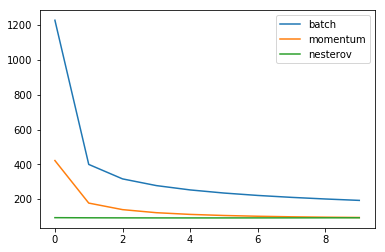

In [21]:
plt.plot(LL_batch, label="batch")                                           
plt.plot(LL_momentum, label="momentum")                                     
plt.plot(LL_nest, label="nesterov")                                         
plt.legend()                                                                
plt.show()